# Jetson Nano를 사용해서 Federated Learning으로 학습 과제

* 이전 실습에서 Django를 가지고 서버를 만들고 Federated learning을 진행해보는 실습을 진행하였다.
* 이번 과제에서는 실제 Jetson Nano를 사용해서 Federated Learning을 진행해본다.

* ```Jetson```클래스를 사용해서 여러 개의 Jetson nano에 동시에 커맨드를 보냄
* 현재 Jetson Nano는 20101 ~ 20106, 20111 ~ 20116, 20121 ~ 20126, ~~20131 ~ 20136~~포트가 사용 가능함
* 각 조당 사용할 수 있는 Jetson Nano가 정해져 있으므로 스프레드시트를 참고

In [1]:
from IPython.display import clear_output
import logging, socket, paramiko.ssh_exception
import fabric
from fabric import Connection, Config, SerialGroup, ThreadingGroup, exceptions, runners
from fabric.exceptions import GroupException
from random import random
import numpy as np

In [2]:
error_ports = [20113]

In [3]:
import time
import threading

class Jetson:
    def __init__(self, min_port, max_port):
        self.address = "147.47.200.209"
        self.username, self.password = "jetson", "jetson"
        self.ports = [i for i in range(int(min_port), int(max_port)+1) if 1<=i%10<=6 and i not in error_ports]
        self.ssh_ports = []
        self.connections = []
        
    def check(self):
        for port in self.ports:
            con = Connection(f'{self.username}@{self.address}:{port}', connect_kwargs ={"password":self.password})
            command = 'ls'
            print(f'----------------{port}----------------')
            try:
                con.run(command)
                self.ssh_ports.append(port)
                self.connections.append(con)
            except:
                print('ERROR')

        print("Available ports", self.ssh_ports)
        return len(self.ssh_ports)
            
    
    
    def send_command(self, command):
        for port, con in zip(self.ssh_ports, self.connections): 
            print(f'----------------{port}----------------')
            try:
                con.run(command)

            except:
                print('ERROR')

                        
    def start_fed(self, experiment, delay, max_round, num_samples, num_clients):        
        for i, (port, con) in enumerate(zip(self.ssh_ports, self.connections)):
            command = f'docker exec client python3 /ambient_fl/client.py --round {max_round} --delay {delay} --num {num_samples} --id {i} --exp {experiment}'
            print(f'----------------{port}----------------')
            try:
                t=threading.Thread(target=con.run,args=(command,))
                t.start()
                time.sleep(delay)
            except:
                print('ERROR')

# Jetson class
* 아래 셀을 실행시키면 Jetson 클래스를 인스턴스화
* ```jetson.check()```를 실행시키면 사용 가능 포트가 어떤게 있는지 알려줌 (처음 커맨드 ```ls```)
    * ```jetson.start_fed()``` 함수를 실행시키기 전 무조건 실행 시켜야 함

In [5]:
jetson = Jetson(min_port = MIN_PORT, max_port=MAX_PORT)
CLIENT_NUM = jetson.check() # 통신 전에 무조건 실행되야 함

----------------20101----------------
ambient_fl
Desktop
Documents
Downloads
examples.desktop
FedML-IoT
FL
jetson
jetson_network.sh
Music
Pictures
Public
Templates
Videos
----------------20102----------------
ambient_fl
Desktop
Documents
Downloads
examples.desktop
FL
jetson
jetson_network.sh
Music
Pictures
Public
Templates
Videos
----------------20103----------------
ambient_fl
Desktop
Documents
Downloads
examples.desktop
FL
jetson
jetson_network.sh
Music
Pictures
Public
Templates
Videos
Available ports [20101, 20102, 20103]


# 변수 변경

* 아래 커맨드를 통해 서버를 초기화 시키고, 클라이언트 수, 실험, 전체 round 수를 서버에 알려줄 수 있음
* 초기화가 성공한 경우 ```<Response [200]> Initialized server>``` 라고 뜰 것
* 에러가 나는 경우 도커 서버를 켰는지 확인

In [4]:
# 스프레드시트에 올라가 있는 MIN_PORT~MAX_PORT
MIN_PORT = 20101 
MAX_PORT = 20103
# 아래 변수들 자유롭게 변경
EXPERIMENT = 1 # 1,2,3
MAX_ROUND = 10 
NUM_SAMPLES = 100
TIME_DELAY = 4

In [6]:
import requests
init = requests.get(f"http://147.47.200.178:9103/initialize/{CLIENT_NUM}/{EXPERIMENT}/{MAX_ROUND}")
print(init, init.text)

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

---

* 서버 터미널

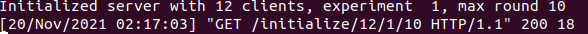

# Jetson methods
* ```Jetson.send_command```를 통해서 커맨드를 보낼 수 있음
* 필요한 커맨드는 전부 아래에 있음

### 1.전체 컨테이너 보기
* 아래 커맨드를 실행해서 실행중인 client가 있는 경우 정지해야함 

In [249]:
jetson.send_command("docker ps -a")

----------------20101----------------
CONTAINER ID   IMAGE                           COMMAND       CREATED          STATUS          PORTS     NAMES
4420b72fb8e2   crazyboy9103/jetson_fl:latest   "/bin/bash"   16 minutes ago   Up 16 minutes             client
----------------20102----------------
CONTAINER ID   IMAGE                           COMMAND       CREATED          STATUS          PORTS     NAMES
683bb90a63ee   crazyboy9103/jetson_fl:latest   "/bin/bash"   16 minutes ago   Up 15 minutes             client
----------------20103----------------
CONTAINER ID   IMAGE                           COMMAND       CREATED          STATUS          PORTS     NAMES
2b581b8853d7   crazyboy9103/jetson_fl:latest   "/bin/bash"   15 minutes ago   Up 15 minutes             client


### 2.실행중인 다른 모든 컨테이너 정지

In [228]:
jetson.send_command("docker stop $(docker ps -a -q)")

----------------20101----------------
9a53d91c2c8c
----------------20102----------------
a47880b6eea1
----------------20103----------------
c02d007f9708
----------------20105----------------
a532046dad12
----------------20106----------------
aa92a4e97c62
----------------20111----------------
c01ec103995b
----------------20112----------------
462ea64b46af
----------------20113----------------
dc835532e2a6
----------------20114----------------
37a467e386f8
----------------20115----------------
7edad0611505
----------------20116----------------
38bc4ff49016


### 3. 정지된 컨테이너 실행

In [211]:
jetson.send_command("docker start client")

----------------20131----------------
client
----------------20132----------------
client
----------------20133----------------
client
----------------20134----------------
client
----------------20135----------------
client
----------------20136----------------
client


### 4.docker 이미지 최신으로 업데이트 (불필요)

In [7]:
#jetson.send_command("docker pull crazyboy9103/jetson_fl:latest")

### 5. client라는 이름의 컨테이너를 실행 (불필요)

In [8]:
#jetson.send_command("docker run -d -ti --name client --gpus all --privileged crazyboy9103/jetson_fl:latest")

* 아래 커맨드를 통해 ```MIN_PORT``` 부터 ```MAX_PORT```까지 federated learning을 시작한다. (결과는 서버에 쌓임) 

### 6. 컨테이너 삭제 (불필요)
* 위에서 생성한 client라는 컨테이너를 삭제한다

In [10]:
#jetson.send_command("docker rm client")

## 7. Federated Learning 시작
* 시작을 했다가 에러가 났다면 커맨드 2로 컨테이너들을 멈추고 커맨드 3으로 컨테이너를 재시작
* 다음 커맨드를 통해 재시작 할수도 있음
* 클라이언트 수가 증가하면, ```TIME_DELAY```를 어느정도 늘려줘야 안전함 

In [250]:
import requests
init = requests.get(f"http://147.47.200.178:9103/initialize/{CLIENT_NUM}/{EXPERIMENT}/{MAX_ROUND}")
print(init, init.text)
jetson.start_fed(experiment=EXPERIMENT, 
                 delay=TIME_DELAY,
                 max_round=MAX_ROUND,
                 num_samples=NUM_SAMPLES,
                 num_clients=CLIENT_NUM)

<Response [200]> Initialized server
----------------20101----------------


2021-11-22 08:10:43.636206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2


----------------20102----------------


2021-11-22 08:10:47.350035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 08:10:47.764147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-22 08:10:47.771219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1046] ARM64 does not support NUMA - returning NUMA node zero
2021-11-22 08:10:47.771467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1742] Found device 0 with properties: 
pciBusID: 0000:00:00.0 name: NVIDIA Tegra X1 computeCapability: 5.3
coreClock: 0.9216GHz coreCount: 1 deviceMemorySize: 3.87GiB deviceMemoryBandwidth: 194.55MiB/s
2021-11-22 08:10:47.771544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 08:10:47.775288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.1

----------------20103----------------


2021-11-22 08:10:51.455878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-22 08:10:51.417956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 08:10:51.462596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1046] ARM64 does not support NUMA - returning NUMA node zero
2021-11-22 08:10:51.462748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1742] Found device 0 with properties: 
pciBusID: 0000:00:00.0 name: NVIDIA Tegra X1 computeCapability: 5.3
coreClock: 0.9216GHz coreCount: 1 deviceMemorySize: 3.87GiB deviceMemoryBandwidth: 194.55MiB/s
2021-11-22 08:10:51.462808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-22 08:10:51.466245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.1

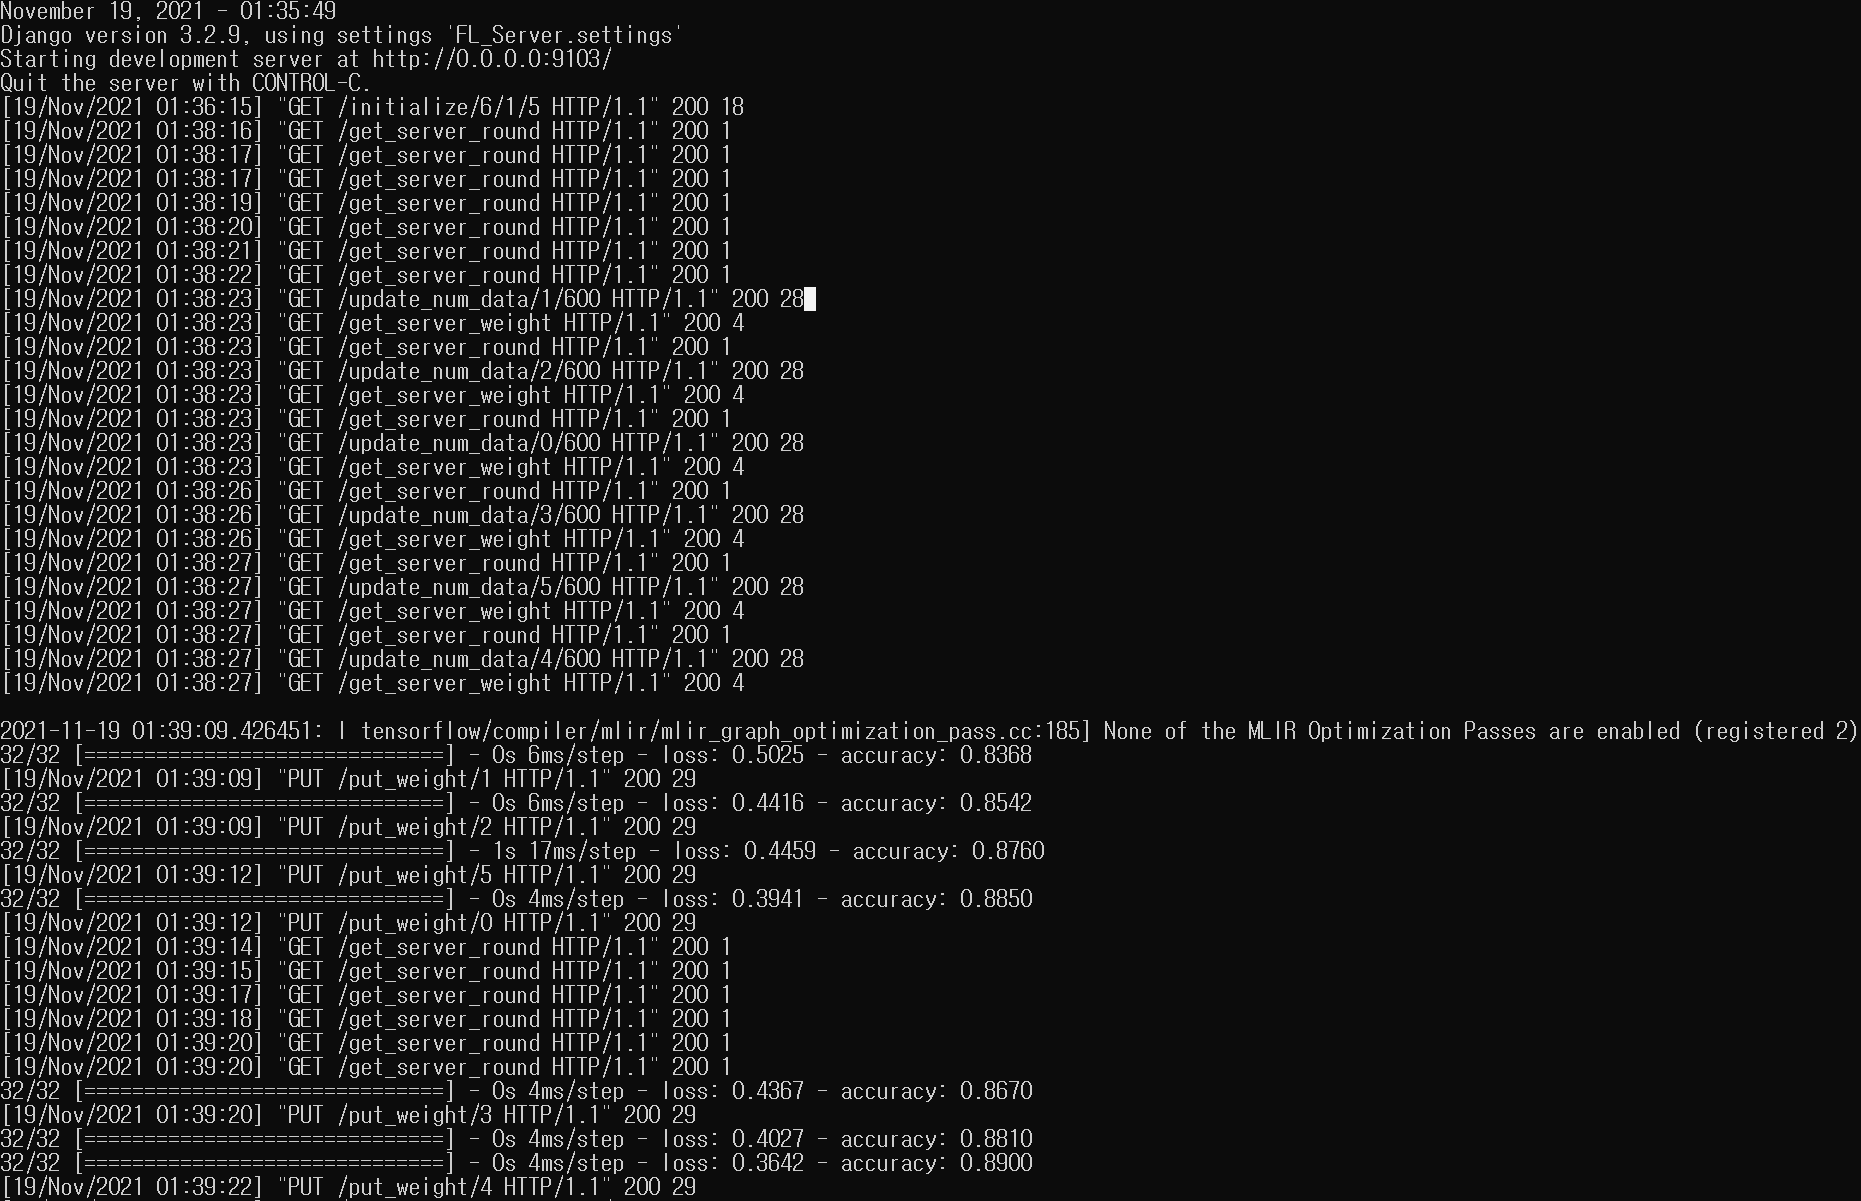

* 학습이 전부 완료되면 결과는 Logs 폴더 내에 json 형태로 저장되게 됨
* 실습때와  똑같이 이미지를 가져오면 됨

# 과제
* 이번 과제는 직접 학교 서버에 접속해서 Jetson Nano 들로 학습시켜 결과를 리포트 하는 것이다


* 각각 experiment 1,2,3을 변경해가면서 결과를 봐도 되고, parameter들을 변경해서 학습시켜 결과를 봐도 된다.
* 실습 때와 마찬가지로 학습을 통해 json 파일을 얻고, ```plot.py```를 통해 이미지 파일로 변환시켜 리포트에 포함한다

* <b>중요!! 이번 과제는 각각 사용할 수 있는 포트가 정해져 있다. 아래 스프레드시트 참고</b>
* Jetson Nano 6개 기준, time delay 5초, 600개 학습 데이터 기준으로 1 round에 1분 정도 소요됨
* 과제에는 6명당 Jetson Nano 3개를 사용
* 접속 계정, 비밀번호, ip주소도 스프레드시트 안에 적혀 있음
    
 https://docs.google.com/spreadsheets/d/1zawhEcjWj559MVsxB7qR6eWFt2ri5lKcNU643f4IMso/edit#gid=0


* 리포트 양식은 없고, 자유롭게 쓰면 됨

* 명령어 실행에 필요한 변수들을 정의
    * ```MIN_PORT``` : 최소 포트값 
    * ```MAX_PORT``` : 최대 포트값
    * ```EXPERIMENT``` : experiment 번호
    * ```MAX_ROUND``` : 학습할 round
    * ```NUM_SAMPLES``` : 각 클라이언트에서 학습에 사용할 수 있는 데이터의 개수 (experiment 3에 대해서는 무시)
    * ```CLIENT_NUM``` : 클라이언트 수